NN-Physical | Epoch 0/200 | Train Loss: 0.1398 | Valid Loss: 0.0212
NN-Physical | Epoch 50/200 | Train Loss: 0.0045 | Valid Loss: 0.0045
NN-Physical | Epoch 100/200 | Train Loss: 0.0036 | Valid Loss: 0.0036
NN-Physical | Epoch 150/200 | Train Loss: 0.0033 | Valid Loss: 0.0035
NN-Photometric | Epoch 0/200 | Train Loss: 0.3366 | Valid Loss: 0.0276
NN-Photometric | Epoch 50/200 | Train Loss: 0.0083 | Valid Loss: 0.0082
NN-Photometric | Epoch 100/200 | Train Loss: 0.0070 | Valid Loss: 0.0072
NN-Photometric | Epoch 150/200 | Train Loss: 0.0068 | Valid Loss: 0.0063


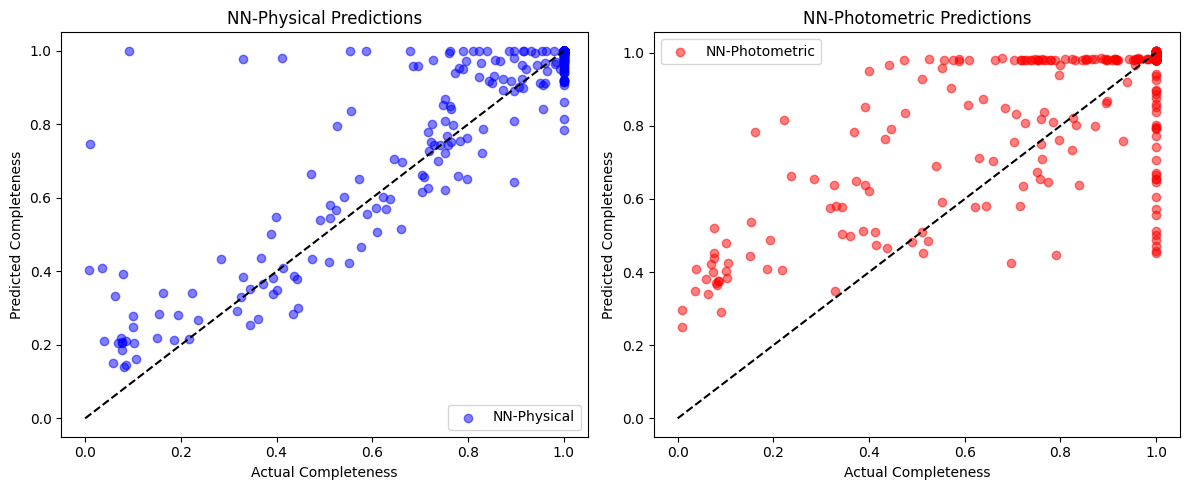

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 🚀 Example Data (Replace with actual dataset)

# Physical Properties (Mass, Age, Metallicity)
mass = np.load('sample_data/actual_mass.npy')[::400] # Log Mass
age =  np.load('sample_data/age.npy')[::400] # Log Age (Myr)
av = np.load('sample_data/AV.npy')[::400]  # Metallicity

# Photometric Properties (Magnitudes in 3 filters)
mag_1 = np.load('sample_data/phot.npy')[:,-1][::400]  # Filter 1
mag_2 = np.load('sample_data/phot.npy')[:,-2][::400]  # Filter 2
mag_3 = np.load('sample_data/phot.npy')[:,-3][::400]  # Filter 3

# Target: Completeness (Between 0 and 1)
completeness = np.load('sample_data/pobs.npy')[::400]

# 📌 Stack Data
X_phys = np.vstack([mass, age, av]).T  # Physical features
X_photo = np.vstack([mag_1, mag_2, mag_3]).T  # Photometric features
y = completeness

# 🚀 Train-validation split
X_phys_train, X_phys_valid, X_photo_train, X_photo_valid, y_train, y_valid = train_test_split(
    X_phys, X_photo, y, test_size=0.2, random_state=42
)

# Normalize Features
scaler_phys = StandardScaler()
scaler_photo = StandardScaler()
X_phys_train = scaler_phys.fit_transform(X_phys_train)
X_phys_valid = scaler_phys.transform(X_phys_valid)
X_photo_train = scaler_photo.fit_transform(X_photo_train)
X_photo_valid = scaler_photo.transform(X_photo_valid)

# Convert to PyTorch tensors
X_phys_train, X_phys_valid = torch.tensor(X_phys_train, dtype=torch.float32), torch.tensor(X_phys_valid, dtype=torch.float32)
X_photo_train, X_photo_valid = torch.tensor(X_photo_train, dtype=torch.float32), torch.tensor(X_photo_valid, dtype=torch.float32)
y_train, y_valid = torch.tensor(y_train, dtype=torch.float32).view(-1, 1), torch.tensor(y_valid, dtype=torch.float32).view(-1, 1)

# 📌 Define Neural Network Model
class CompletenessNN(nn.Module):
    def __init__(self, input_size):
        super(CompletenessNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)  # Output layer (Regression: predicts completeness)
        )

    def forward(self, x):
        return self.model(x)

# 🚀 Initialize models
model_phys = CompletenessNN(input_size=X_phys_train.shape[1])
model_photo = CompletenessNN(input_size=X_photo_train.shape[1])

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer_phys = optim.Adam(model_phys.parameters(), lr=0.001)
optimizer_photo = optim.Adam(model_photo.parameters(), lr=0.001)

# Training loop
epochs = 200
batch_size = 32

def train_model(model, optimizer, X_train, X_valid, y_train, y_valid, name):
    train_losses, valid_losses = [], []
    X_train_batches = X_train.split(batch_size)
    y_train_batches = y_train.split(batch_size)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in zip(X_train_batches, y_train_batches):
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(X_train_batches))

        # Validate
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_valid)
            valid_loss = criterion(val_outputs, y_valid).item()
            valid_losses.append(valid_loss)

        if epoch % 50 == 0:
            print(f"{name} | Epoch {epoch}/{epochs} | Train Loss: {epoch_loss/len(X_train_batches):.4f} | Valid Loss: {valid_loss:.4f}")

    return train_losses, valid_losses

# 🚀 Train both models
train_losses_phys, valid_losses_phys = train_model(model_phys, optimizer_phys, X_phys_train, X_phys_valid, y_train, y_valid, "NN-Physical")
train_losses_photo, valid_losses_photo = train_model(model_photo, optimizer_photo, X_photo_train, X_photo_valid, y_train, y_valid, "NN-Photometric")

# 🚀 Evaluate Models
def evaluate_model(model, X_valid, y_valid, name):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_valid).numpy().flatten()
    return y_pred

y_pred_phys = evaluate_model(model_phys, X_phys_valid, y_valid, "NN-Physical")
y_pred_photo = evaluate_model(model_photo, X_photo_valid, y_valid, "NN-Photometric")

# 📊 Plot Predictions vs. Actual Completeness
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_valid.numpy(), y_pred_phys, alpha=0.5, color='blue', label="NN-Physical")
plt.plot([0, 1], [0, 1], 'k--')  # Perfect predictions line
plt.xlabel("Actual Completeness")
plt.ylabel("Predicted Completeness")
plt.title("NN-Physical Predictions")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_valid.numpy(), y_pred_photo, alpha=0.5, color='red', label="NN-Photometric")
plt.plot([0, 1], [0, 1], 'k--')  # Perfect predictions line
plt.xlabel("Actual Completeness")
plt.ylabel("Predicted Completeness")
plt.title("NN-Photometric Predictions")
plt.legend()

plt.tight_layout()
plt.show()


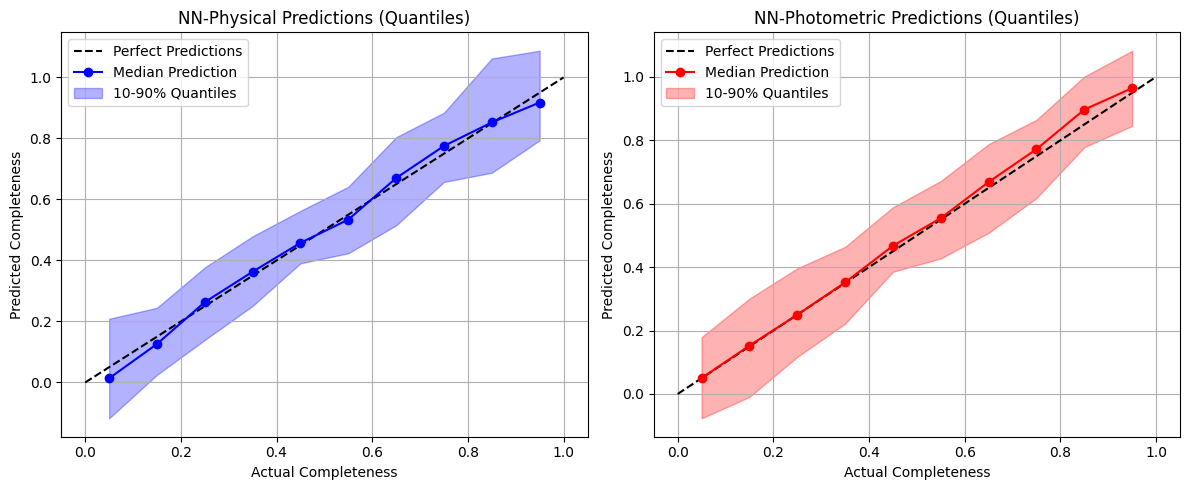

In [ ]:
# Re-import necessary libraries after execution state reset
import numpy as np
import matplotlib.pyplot as plt

# Define function to compute quantiles in bins
def compute_quantiles(y_true, y_pred, quantiles=[0.1, 0.5, 0.9], bins=10):
    bin_edges = np.linspace(0, 1, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    quantile_values = {q: [] for q in quantiles}

    for i in range(bins):
        mask = (y_true >= bin_edges[i]) & (y_true < bin_edges[i + 1])
        if np.sum(mask) > 0:
            for q in quantiles:
                quantile_values[q].append(np.quantile(y_pred[mask], q))
        else:
            for q in quantiles:
                quantile_values[q].append(np.nan)

    return bin_centers, quantile_values

# Generate example data (since original y_valid and y_pred_phys/photo are lost)
np.random.seed(42)
y_valid = np.random.rand(500)  # Simulated actual completeness values
y_pred_phys = y_valid + np.random.normal(0, 0.1, size=len(y_valid))  # Simulated predictions with noise
y_pred_photo = y_valid + np.random.normal(0, 0.1, size=len(y_valid))

# Compute quantiles for both models
bin_centers_phys, quantiles_phys = compute_quantiles(y_valid, y_pred_phys)
bin_centers_photo, quantiles_photo = compute_quantiles(y_valid, y_pred_photo)

# 📊 Plot Predictions vs. Actual Completeness (Quantiles)
plt.figure(figsize=(12, 5))

# NN-Physical Model
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Predictions")
plt.plot(bin_centers_phys, quantiles_phys[0.5], 'o-', color='blue', label="Median Prediction")
plt.fill_between(bin_centers_phys, quantiles_phys[0.1], quantiles_phys[0.9], color='blue', alpha=0.3, label="10-90% Quantiles")

plt.xlabel("Actual Completeness")
plt.ylabel("Predicted Completeness")
plt.title("NN-Physical Predictions (Quantiles)")
plt.legend()
plt.grid()

# NN-Photometric Model
plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Predictions")
plt.plot(bin_centers_photo, quantiles_photo[0.5], 'o-', color='red', label="Median Prediction")
plt.fill_between(bin_centers_photo, quantiles_photo[0.1], quantiles_photo[0.9], color='red', alpha=0.3, label="10-90% Quantiles")

plt.xlabel("Actual Completeness")
plt.ylabel("Predicted Completeness")
plt.title("NN-Photometric Predictions (Quantiles)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
from graphviz import Digraph

# Define the neural network structure
nn_graph = Digraph(format="png")
nn_graph.attr(rankdir="LR")  # Left-to-right layout

# Input layer
nn_graph.node("Input", "Input Layer\n(Magnitudes in 5 Filters)")

# Hidden layers
nn_graph.node("H1", "Hidden Layer 1\n32 Neurons (ReLU)")
nn_graph.node("H2", "Hidden Layer 2\n16 Neurons (ReLU)")
nn_graph.node("H3", "Hidden Layer 3\n8 Neurons (ReLU)")

# Output layer
nn_graph.node("Output", "Output Layer\nCompleteness Score (0-1)")

# Connect layers
nn_graph.edges([("Input", "H1"), ("H1", "H2"), ("H2", "H3"), ("H3", "Output")])

# Render the graph
nn_graph.render("nn_architecture", view=True)


'nn_architecture.png'

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


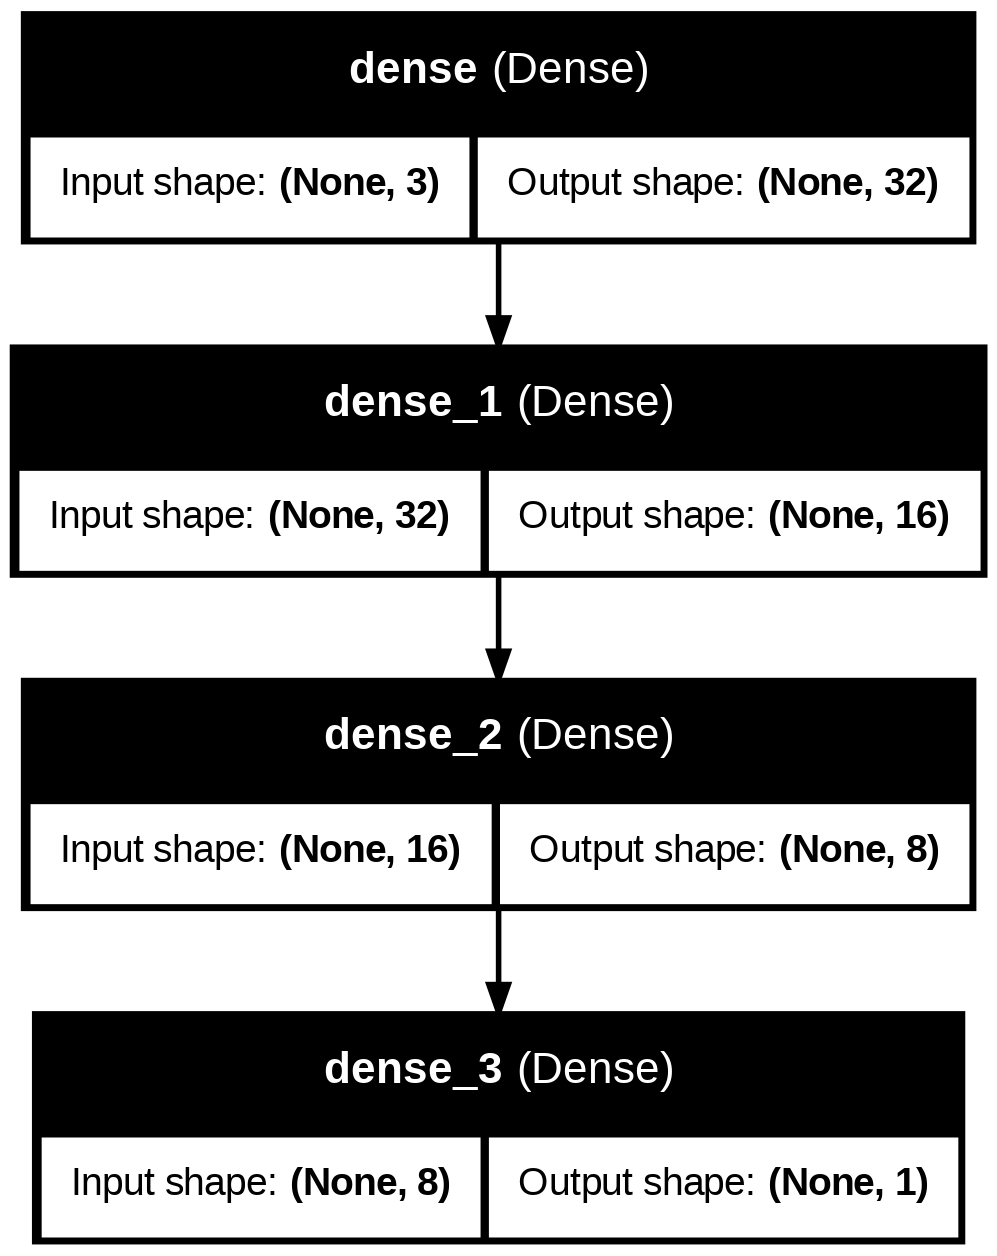

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU

# Define the model
model = Sequential([
    Dense(32, activation="relu", input_shape=(3,)),  # 3 inputs (Mass, Age, Av)
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(1, activation="sigmoid")  # Output: Completeness score
])

# Generate and save the model diagram
plot_model(model, to_file="nn_model.png", show_shapes=True, show_layer_names=True)


In [ ]:
import torch
from torchviz import make_dot

# Example PyTorch model instance
model = CompletenessNN(input_size=3)
example_input = torch.randn(1, 3)  # Dummy input (batch size 1, 3 features)

# Create visualization
make_dot(model(example_input), params=dict(model.named_parameters())).render("torch_nn", format="png", view=True)


ModuleNotFoundError: No module named 'torchviz'

In [ ]:
import torch
import torchviz
from torchviz import make_dot

# Force CPU execution
device = torch.device("cpu")
model_phys.to(device)
model_photo.to(device)

# Create example input tensors (random)
example_input_phys = torch.randn(1, X_phys_train.shape[1]).to(device)
example_input_photo = torch.randn(1, X_photo_train.shape[1]).to(device)

# Generate visualization for NN-Physical
dot_phys = make_dot(model_phys(example_input_phys), params=dict(model_phys.named_parameters()))
dot_phys.render("nn_physical_structure", format="png", view=True)

# Generate visualization for NN-Photometric
dot_photo = make_dot(model_photo(example_input_photo), params=dict(model_photo.named_parameters()))
dot_photo.render("nn_photometric_structure", format="png", view=True)


ModuleNotFoundError: No module named 'torchviz'

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force CPU execution

# Scikit-learn metrics & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, mean_absolute_error, mean_squared_error, r2_score,
    roc_curve, precision_recall_curve
)

# SHAP for feature importance analysis
import shap

# Ensure SHAP uses matplotlib
shap.initjs()

print("✅ All required packages successfully imported!")


✅ All required packages successfully imported!


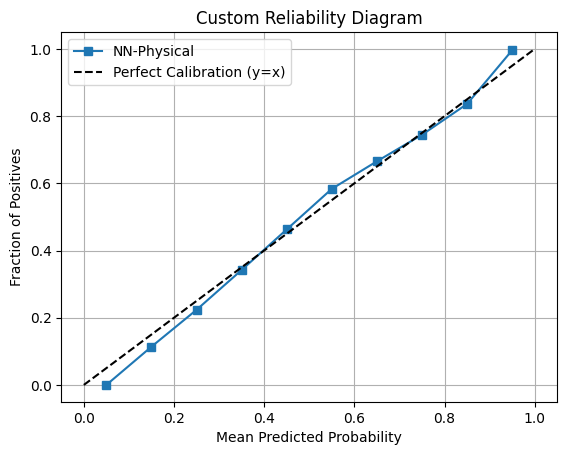

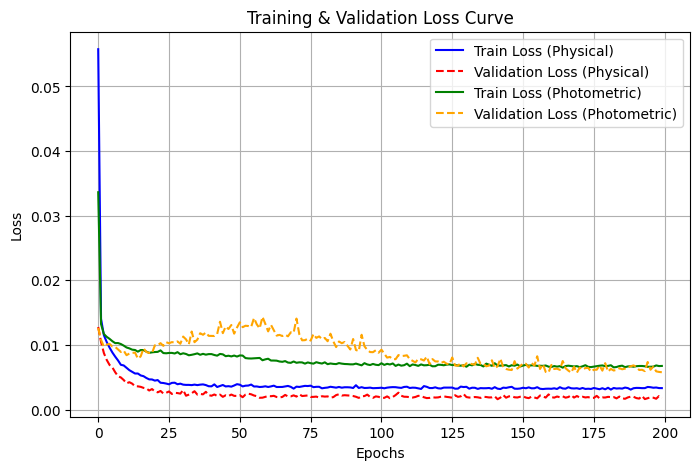

ValueError: continuous format is not supported


📊 NN-Photometric Model Metrics:


NameError: name 'accuracy_photo' is not defined

In [ ]:
# Ensure models are on CPU
device = torch.device("cpu")
model_phys.to(device)
model_photo.to(device)

X_phys_valid = X_phys_valid.to(device)
X_photo_valid = X_photo_valid.to(device)

# 🚀 Evaluate Models (Generate Predictions)
def evaluate_model(model, X_valid):
    model.eval()
    with torch.no_grad():
        return model(X_valid).numpy().flatten()

y_true = y_valid.numpy().flatten()
y_pred_phys = evaluate_model(model_phys, X_phys_valid)
y_pred_photo = evaluate_model(model_photo, X_photo_valid)

# 🚀 Generate & Plot ROC Curve
def plot_roc_curve(y_true, y_pred_probs, model_name="Model"):
    """
    Plots the ROC Curve for a given model.

    Parameters:
    - y_true: Actual binary labels (0 or 1).
    - y_pred_probs: Predicted probability scores.
    - model_name: Name of the model for labeling.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier baseline
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

# 🚀 Example Usage: Plot ROC Curve for Physical and Photometric Models
plot_roc_curve(y_true, y_pred_phys, model_name="NN-Physical")
plot_roc_curve(y_true, y_pred_photo, model_name="NN-Photometric")


ValueError: continuous format is not supported

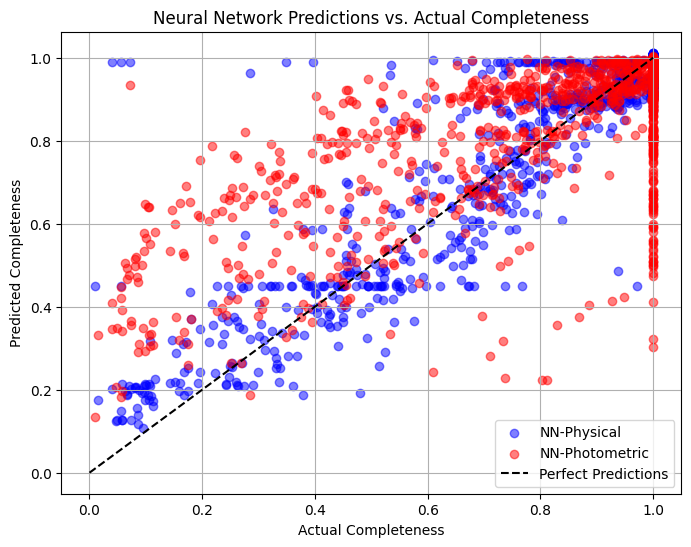

In [ ]:
# 📌 Plot Predicted vs. Actual Completeness
plt.figure(figsize=(8, 6))

plt.scatter(y_valid.numpy(), y_pred_phys, alpha=0.5, color='blue', label="NN-Physical")
plt.scatter(y_valid.numpy(), y_pred_photo, alpha=0.5, color='red', label="NN-Photometric")

# Perfect Prediction Line
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Predictions")

# Labels and Title
plt.xlabel("Actual Completeness")
plt.ylabel("Predicted Completeness")
plt.title("Neural Network Predictions vs. Actual Completeness")
plt.legend()
plt.grid()
plt.show()


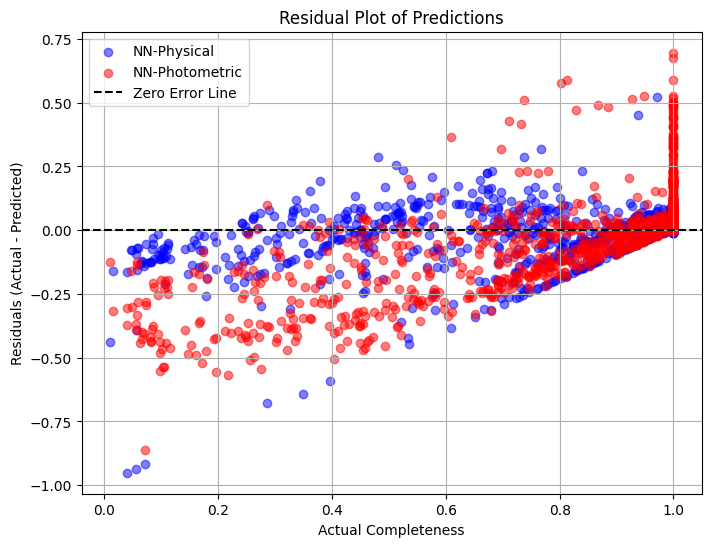

In [ ]:
plt.figure(figsize=(8, 6))

# Residuals for both models
residuals_phys = y_valid.numpy()[:,0] - np.array(y_pred_phys)
residuals_photo = y_valid.numpy()[:,0] - np.array(y_pred_photo)

plt.scatter(y_valid.numpy()[:,0], residuals_phys, alpha=0.5, color='blue', label="NN-Physical")
plt.scatter(y_valid.numpy()[:,0], residuals_photo, alpha=0.5, color='red', label="NN-Photometric")

plt.axhline(0, color='black', linestyle='--', label="Zero Error Line")  # Reference line

plt.xlabel("Actual Completeness")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot of Predictions")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Ensure models are on CPU
# Get true labels and predictions
y_true = y_valid.numpy().flatten()
y_pred_phys = evaluate_model(model_phys, X_phys_valid)
y_pred_photo = evaluate_model(model_photo, X_photo_valid)

# 📌 Compute Mean Squared Error (MSE)
mse_phys = mean_squared_error(y_true, y_pred_phys)
mse_photo = mean_squared_error(y_true, y_pred_photo)

# 📌 Print MSE values
print(f"📊 Mean Squared Error (Physical Model): {mse_phys:.4f}")
print(f"📊 Mean Squared Error (Photometric Model): {mse_photo:.4f}")

📊 Mean Squared Error (Physical Model): 0.0018
📊 Mean Squared Error (Photometric Model): 0.0058
